In [49]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from IPython.display import HTML

import torch
from torch.utils.data import Dataset, dataloader
import torch.nn.functional as F
from torchsummary import summary

import sys
sys.path.append('../src')
from model import *
from Animation import AnimatedScatter
from datagen import DataGen

### Data generation

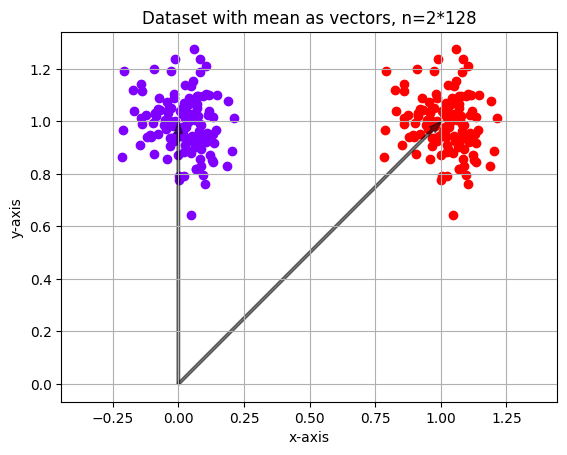

In [50]:
n_categories = 2
n_p = 128 # points_per_category


# sym, as, as_extra, parallel, manual
datatype = "manual"
as_pos = np.array([[0,1],[1,1]])
noise = False
dataclass = DataGen(n_categories, n_p, scale=1, name=datatype, seed=1234, as_pos=as_pos,noise=noise)
centers,data,labels = dataclass.centers,dataclass.data,dataclass.labels

dataclass.plot()

if noise:
    n_categories += 1

# centers,data,labels = data_gen(n_categories,n_p,scale=1)
# centers,data,labels = data_gen_as_extra(n_categories,n_p,scale=1)

### Putting data in PyTorch dataset

In [51]:
class ScatterData(Dataset):
    def __init__(self,points,labels,n_cat):
        self.x = torch.tensor(points).float()
        self.y = torch.tensor(labels).to(int)
        self.y = F.one_hot(self.y, num_classes=n_cat).double()
    def __len__(self): 
        return self.x.shape[0]
    def __getitem__(self, ix): 
        return self.x[ix], self.y[ix]

In [52]:
BATCH_SIZE = 32

training_data = ScatterData(data,labels,n_categories)
training_loader = torch.utils.data.DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)

### Create model

In [53]:
# model = UMI_L1(2,n_categories,lr=1e-3)
# model = UMI(2,n_categories,lr=0.01,bias=False)
model = UMI_Jacobi_2_savegrad(2,n_categories,lr=0.001,bias=False,decay=1,orthogonal=False)
# model = UMI_J2(2,n_categories,lr=0.01,bias=False,decay=0.01)
# model = UMI_SVB_soft(2,n_categories,lr=0.001,bias=False,decay=0.01)

# summary(model,input_size=(1,2))

In [54]:
print(training_data[0][0])

tensor([0.0471, 0.8809])


In [55]:
# model.area_test()
# model.area_test_multiD()

### Training

In [56]:
w_his = []

In [57]:
def train(loader,model,n_epochs=5,area=False):
    """Network training function

    Arguments:
        loader -- pytorch dataloader object of training data
        model -- pytorch nn object, neural network model

    Keyword Arguments:
        n_epochs -- number of epochs for training (default: {5})

    Returns:
        epochs, losses -- numpy arrays of epoch numbers (with decimals representing each batch) and loss values for each batch
    """
    losses = []
    epochs = []
    areas = []
    areas_mD = []
    N = len(loader)
    for epoch in tqdm(range(n_epochs)):
        for param in model.parameters():
            w = param
            w_np = w.detach().numpy().copy()
            w_his.append(w_np)
        for i, (inputs,labels) in tqdm(enumerate(loader)):
            loss = model.train_step(inputs,labels)
            losses.append(loss)
            epochs.append(epoch+i/N)
            areas.append(model.area_test())
            areas_mD.append(model.area_test_multiD())
    return np.array(epochs), np.array(losses), np.array(areas), np.array(areas_mD)

# Trainer for hard SVB
def train_SVB(loader,model,n_epochs=5):
    """Network training function for hard SVB
    """
    losses = []
    epochs = []
    N = len(loader)
    for epoch in tqdm(range(n_epochs)):
        model.SVB(eps=0.001)
        for param in model.parameters():
            w = param
            w_np = w.detach().numpy().copy()
            w_his.append(w_np)
        for i, (inputs,labels) in tqdm(enumerate(loader)):
            loss = model.train_step(inputs,labels)
            losses.append(loss)
            epochs.append(epoch+i/N)
    return np.array(epochs), np.array(losses)

In [58]:
def train_jacobi(loader,model,n_epochs=5):
    """Network training function for Jacobi
    """
    losses = []
    epochs = []
    areas = []
    areas_mD = []
    N = len(loader)
    for epoch in tqdm(range(n_epochs)):
        for param in model.parameters():
            w = param
            w_np = w.detach().numpy().copy()
            w_his.append(w_np)
        for i, (inputs,labels) in tqdm(enumerate(loader)):
            loss = model.train_step(inputs,labels)
            losses.append(loss)
            epochs.append(epoch+i/N)
            areas.append(model.area_test())
            areas_mD.append(model.area_test_multiD())
    return np.array(epochs), np.array(losses), np.array(model.cross_losses), np.array(model.jacobi_losses), np.array(areas), np.array(areas_mD)

def train_jacobi_grad_saver(loader,model,n_epochs=5):
    """Network training function for Jacobi
    """
    losses = []
    epochs = []
    areas_mD = []
    
    N = len(loader)
    for epoch in tqdm(range(n_epochs)):
        for param in model.parameters():
            w = param
            w_np = w.detach().numpy().copy()
            w_his.append(w_np)
        for i, (inputs,labels) in tqdm(enumerate(loader)):
            loss = model.train_step(inputs,labels)
            losses.append(loss)
            epochs.append(epoch+i/N)
            # areas_mD.append(model.area_test_multiD())
    return np.array(epochs), np.array(losses), np.array(model.cross_losses), np.array(model.jacobi_losses), np.array(areas_mD), np.array(model.jacobi_grad), np.array(model.cross_grad)

def train_jacobi_flip(loader,model,n_epochs=5):
    """Network training function for Jacobi
    """
    j = 0
    losses = []
    epochs = []
    N = len(loader)
    for epoch in tqdm(range(n_epochs)):
        j += 1
        if j%100 == 0:
            print(last_input,last_label)
            model.flip(last_input,last_label)
        for param in model.parameters():
            w = param
            w_np = w.detach().numpy().copy()
            w_his.append(w_np)
        for i, (inputs,labels) in tqdm(enumerate(loader)):
            loss = model.train_step(inputs,labels)
            model.flip(loader.dataset.x,loader.dataset.y)
            losses.append(loss)
            epochs.append(epoch+i/N)
            if i == 12-1:
                last_input = inputs[0]
                last_label = labels[0]
    return np.array(epochs), np.array(losses), np.array(model.cross_losses), np.array(model.jacobi_losses)

In [59]:
# epoch_data, loss_data, area_data, area_data_mD = train(training_loader,model,n_epochs=500,area=True)
# epoch_data, loss_data, crossloss_data, jacobiloss_data, area_data, area_data_mD = train_jacobi(training_loader,model,n_epochs=500)
epoch_data, loss_data, crossloss_data, jacobiloss_data, area_data_mD, jacobigrad_data, crossgrad_data = train_jacobi_grad_saver(training_loader,model,n_epochs=3000)
# epoch_data, loss_data, crossloss_data, jacobiloss_data = train_jacobi_flip(training_loader,model,n_epochs=500)
# epoch_data, loss_data = train_SVB(training_loader,model,n_epochs=500)

8it [00:00, 395.26it/s] [00:00<?, ?it/s]
8it [00:00, 380.93it/s]
8it [00:00, 444.48it/s]
8it [00:00, 381.01it/s]
8it [00:00, 355.40it/s]
8it [00:00, 380.96it/s] [00:00<01:11, 41.67it/s]
8it [00:00, 371.09it/s]
8it [00:00, 216.17it/s]
8it [00:00, 284.47it/s]
8it [00:00, 407.34it/s]
8it [00:00, 397.69it/s]0 [00:00<01:20, 37.31it/s]
8it [00:00, 371.97it/s]
8it [00:00, 361.17it/s]
8it [00:00, 381.03it/s]
8it [00:00, 380.94it/s]
8it [00:00, 399.98it/s]0 [00:00<01:16, 38.91it/s]
8it [00:00, 380.95it/s]
8it [00:00, 470.59it/s]
8it [00:00, 363.64it/s]
8it [00:00, 380.93it/s]
8it [00:00, 355.32it/s]0 [00:00<01:14, 40.02it/s]
8it [00:00, 417.76it/s]
8it [00:00, 440.29it/s]
8it [00:00, 363.49it/s]
8it [00:00, 349.30it/s]
8it [00:00, 421.09it/s]0 [00:00<01:13, 40.50it/s]
8it [00:00, 316.16it/s]
8it [00:00, 147.55it/s]
8it [00:00, 320.04it/s]
8it [00:00, 391.41it/s]
8it [00:00, 410.02it/s]0 [00:00<01:21, 36.53it/s]
8it [00:00, 355.56it/s]
8it [00:00, 434.93it/s]
8it [00:00, 421.05it/s]
8it [00:00, 

In [46]:
# Find norm of jacobi gradient and cross gradient
# jacobi_grad_norm = np.linalg.norm(jacobiloss_data,axis=1)
# cross_grad_norm = np.linalg.norm(crossloss_data,axis=1)
# print(jacobi_grad_norm.shape)

### Training results visualization

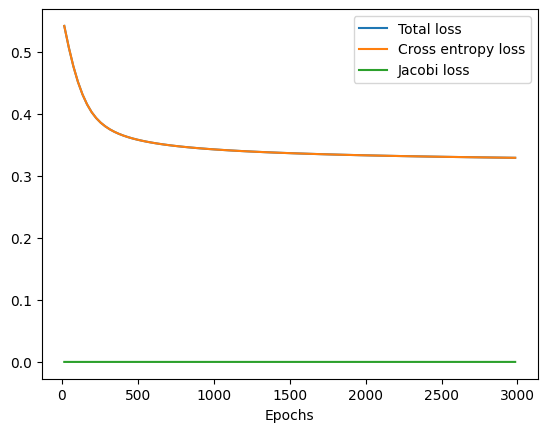

In [66]:
epoch_data_avgd = epoch_data.reshape(100,-1).mean(axis=1) # the number in reshape has to divide the number of epochs
loss_data_avgd = loss_data.reshape(100,-1).mean(axis=1)

plt.plot(epoch_data_avgd,loss_data_avgd, label="Total loss") # Plot the average loss per epoch

crossloss_data_avgd = crossloss_data[:].reshape(100,-1).mean(axis=1)
jacobiloss_data_avgd = jacobiloss_data[:].reshape(100,-1).mean(axis=1)
plt.plot(epoch_data_avgd,crossloss_data_avgd,label="Cross entropy loss") # Plot the average loss per epoch
plt.plot(epoch_data_avgd,jacobiloss_data_avgd, label="Jacobi loss") # Plot the average loss per epoch

# plt.title("Jacobi, 0.01LR, 10decay, 500 epochs, 66% acc")
# plt.plot(epoch_data,area_data, label="Weight Area")
# plt.plot(epoch_data,area_data_mD, label="Weight Area multiD")
plt.xlabel("Epochs")

# plt.plot(epoch_data,loss_data)
plt.legend()
plt.show()

### Testing

In [62]:
# t_centers, test_data, test_labels = data_gen_as_extra(n_categories,512)

test_n = 512

if noise:
    n_categories += -1

# n_categories = 2

test_data = DataGen(n_categories, test_n, scale=1, name=datatype, seed=3141, as_pos=as_pos)
t_centers, test_data, test_labels = test_data.centers,test_data.data,test_data.labels
test_set = ScatterData(test_data,test_labels,n_categories)

acc = (model(test_set.x).argmax(dim=1) == test_set.y.argmax(dim=1)).float().sum().item()/len(test_set)
print(f'Accuracy: {acc:.2f}')

Accuracy: 1.00


### Weights

[Parameter containing:
tensor([[-4.3281,  1.9071],
        [ 3.4987, -1.7727]], requires_grad=True)]


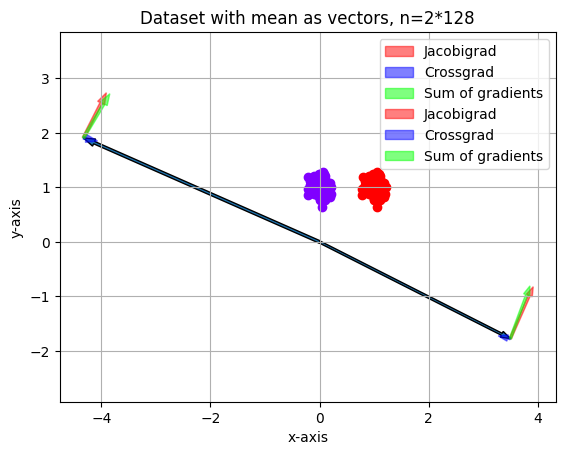

In [64]:
w = []

for param in model.parameters():
    w.append(param)
    print(w)

w_np = w[0].detach().numpy()
if len(w) > 1:
    bias = w[1].detach().numpy()



for i in range(len(w_np)):
    w_len = np.linalg.norm(w_np[i])
    width = 0.01*w_len
    # Weight arrows
    plt.arrow(0,0,w_np[i][0],w_np[i][1],length_includes_head=True,width=width)
    # Gradient arrows
    scale = 10
    plt.arrow(w_np[i][0],w_np[i][1],scale*jacobigrad_data[-1][i][0],scale*jacobigrad_data[-1][i][1],length_includes_head=False,width=width,color=(1,0,0,0.5),label="Jacobigrad")
    plt.arrow(w_np[i][0],w_np[i][1],scale*crossgrad_data[-1][i][0],scale*crossgrad_data[-1][i][1],length_includes_head=False,width=width,color=(0,0,1,0.5),label="Crossgrad")
    # Sum of gradients
    plt.arrow(w_np[i][0],w_np[i][1],scale*(jacobigrad_data[-1][i][0]+crossgrad_data[-1][i][0]),scale*(jacobigrad_data[-1][i][1]+crossgrad_data[-1][i][1]),length_includes_head=False,width=width,color=(0,1,0,0.5),label="Sum of gradients")

colors = cm.rainbow(np.linspace(0,1,n_categories))

plt.legend()
dataclass.plot(arrows=False)
# for col,center,i in zip(colors,centers,range(n_categories)):
#     plt.scatter(data[i*n_p:(i+1)*n_p,0],data[i*n_p:(i+1)*n_p,1],color=col)
#     # plt.arrow(0,0,center[0],center[1],length_includes_head=True,width=0.01,color=(0,0,0,0.5))



# plt.grid()
# plt.axis('equal')

In [37]:
loss_data[::16].shape
w_his = np.array(w_his)
w_his.transpose([0,2,1]).shape

(501, 2, 2)

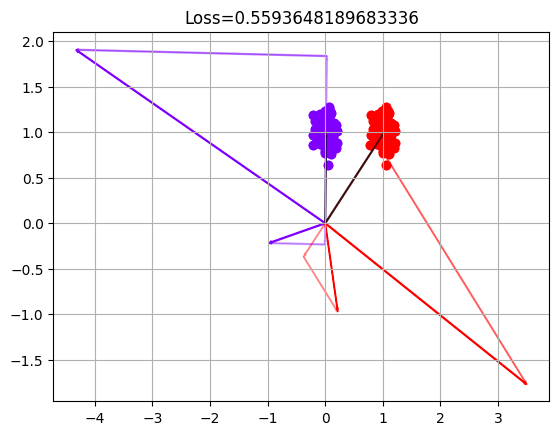

In [65]:
w_his = np.array(w_his)

animated_scatter = AnimatedScatter(data,w_his.transpose([0,2,1]),loss_data,n_clusters=n_categories,acc=acc)
html_object = HTML(animated_scatter.animation.to_html5_video())
html_object